In [71]:
%cd "/home/plent/Documenten/Gitlab/NeuralODEs/symplectic_adjoint"
from developing_sbml.sbml_load import *
import diffrax
from diffrax import diffeqsolve, ODETerm, Dopri5,SaveAt
import numpy as np
import jax.numpy as jnp
import jax

import equinox as eqx  # https://github.com/patrick-kidger/equinox
import matplotlib.pyplot as plt
import optax
import pandas as pd
import logging
import sys
sys.path.append('jax_implementation/developing_sbml/')

from developing_sbml.jax_kinetic_model import NeuralODE, JaxKineticModel

import jax
# needed if system is stiff
jax.config.update("jax_enable_x64", True)

/home/plent/Documenten/Gitlab/NeuralODEs/symplectic_adjoint


In [72]:
### load model
filepath="jax_implementation/developing_sbml/sbml_models/BIOMD0000000051_url.xml"
model=load_sbml_model(file_path=filepath)


S=get_stoichiometric_matrix(model)


y0=get_initial_conditions(model)

y0=jnp.array(list(y0.values()))
##recreate create_fluxes, but then for jax
v,v_symbol_dictionaries,local_params=create_fluxes_v(model)
met_point_dict=construct_flux_pointer_dictionary(v_symbol_dictionaries,list(S.columns),list(S.index))

ts=jnp.arange(0,5,0.1)
JaxKmodel = NeuralODE(v=v, S=S, 
                  met_point_dict=met_point_dict,
                  v_symbol_dictionaries=v_symbol_dictionaries)

JaxKmodel=jax.jit(JaxKmodel)


17:18:59,108 - developing_sbml.sbml_load - INFO - Number of internal inconsistencies: 0


Number of species: 18
Number of reactions: 48
Number of global parameters 7
Number of constant boundary metabolites:  0
Number of lambda function definitions:  0
Number of assignment rules 7


In [108]:
## load data
print(os.getcwd())
data=pd.read_excel("jax_implementation/KIMODATAID30_v1.xlsx",sheet_name=1,header=6)

data=data.iloc[2:,:]

float(data['Glucose [mM]'].iloc[0])

y0_data=data.iloc[0,:]
y0_data=jnp.array([float(i) for i in y0])

ts_data=jnp.array([float(i) for i in data['Time [s]']])

data_pep=jnp.array([float(i) for i in data['PEP [mM]']])
data_glcex=jnp.array([float(i) for i in data['Glucose [mM]']])

/home/plent/Documenten/Gitlab/NeuralODEs/symplectic_adjoint


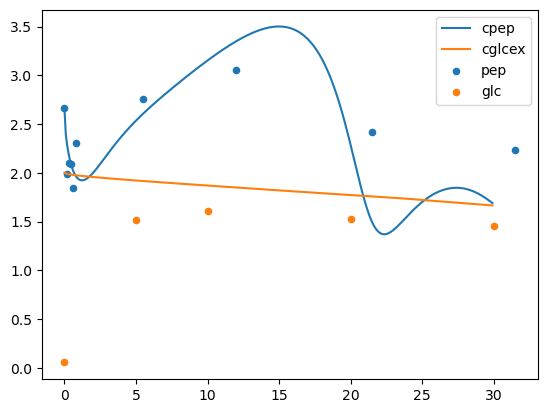

In [111]:
ts=jnp.arange(0,30,0.1)
# #parameters are not yet defined
params=get_global_parameters(model)
params={**local_params,**params}


# # # print(v_local_param_dict)
ys=JaxKmodel(ts=ts,
      y0=y0,
      params=params)

# ys_data=JaxKmodel(ts=ts,
#       y0=y0_data,
#       params=params)

for i in range(2):
      plt.plot(ts,ys[:,i],label=S.index[i])
      # plt.plot(ts,ys_data[:,i],label=S.index[i])
plt.scatter(ts_data,data_pep,s=20,label="pep")
plt.scatter(ts_data,data_glcex,s=20,label="glc")
      

# plt.plot(ts,ys[:,4],label=species_names[4])
plt.legend()
# 
plt.show()

In [112]:
params

{'lp.vPTS.rmaxPTS': 7829.78,
 'lp.vPTS.KPTSa1': 3082.3,
 'lp.vPTS.KPTSa2': 0.01,
 'lp.vPTS.KPTSa3': 245.3,
 'lp.vPTS.nPTSg6p': 3.66,
 'lp.vPTS.KPTSg6p': 2.15,
 'lp.vPGI.rmaxPGI': 650.9878687,
 'lp.vPGI.KPGIeq': 0.1725,
 'lp.vPGI.KPGIg6p': 2.9,
 'lp.vPGI.KPGIf6p': 0.266,
 'lp.vPGI.KPGIf6ppginh': 0.2,
 'lp.vPGI.KPGIg6ppginh': 0.2,
 'lp.vPGM.rmaxPGM': 0.8398242773,
 'lp.vPGM.KPGMeq': 0.196,
 'lp.vPGM.KPGMg6p': 1.038,
 'lp.vPGM.KPGMg1p': 0.0136,
 'lp.vG6PDH.rmaxG6PDH': 1.380196955,
 'lp.vG6PDH.KG6PDHg6p': 14.4,
 'lp.vG6PDH.KG6PDHnadphg6pinh': 6.43,
 'lp.vG6PDH.KG6PDHnadp': 0.0246,
 'lp.vG6PDH.KG6PDHnadphnadpinh': 0.01,
 'lp.vPFK.rmaxPFK': 1840.584747,
 'lp.vPFK.KPFKatps': 0.123,
 'lp.vPFK.KPFKadpc': 4.14,
 'lp.vPFK.KPFKf6ps': 0.325,
 'lp.vPFK.KPFKpep': 3.26,
 'lp.vPFK.KPFKadpb': 3.89,
 'lp.vPFK.KPFKampb': 3.2,
 'lp.vPFK.KPFKadpa': 128.0,
 'lp.vPFK.KPFKampa': 19.1,
 'lp.vPFK.LPFK': 5629067.0,
 'lp.vPFK.nPFK': 11.1,
 'lp.vTA.rmaxTA': 10.87164108,
 'lp.vTA.KTAeq': 1.05,
 'lp.vTKA.rmaxTKa': 9.